In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '3' # for windows threading issue

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score
from collections import Counter
from kneed import KneeLocator
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# You are provided with a dataset leaves.csv, which contains 5 attributes of various plant leaves: Leaf
# length, Leaf width, Color intensity, Vein density, Symmetry score. The dataset includes a
# header, and the values are delimited by semicolons. Furthermore, in the last column is given the
# leaf type (symbolically), but you will hide this column to the given subtasks, except for task 5.

In [3]:
df = pd.read_csv('data/leaves.csv', delimiter=';')
true_labels = df['Leaf_Type'].copy()
df_clustering = df.drop('Leaf_Type', axis=1)

# Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_clustering)

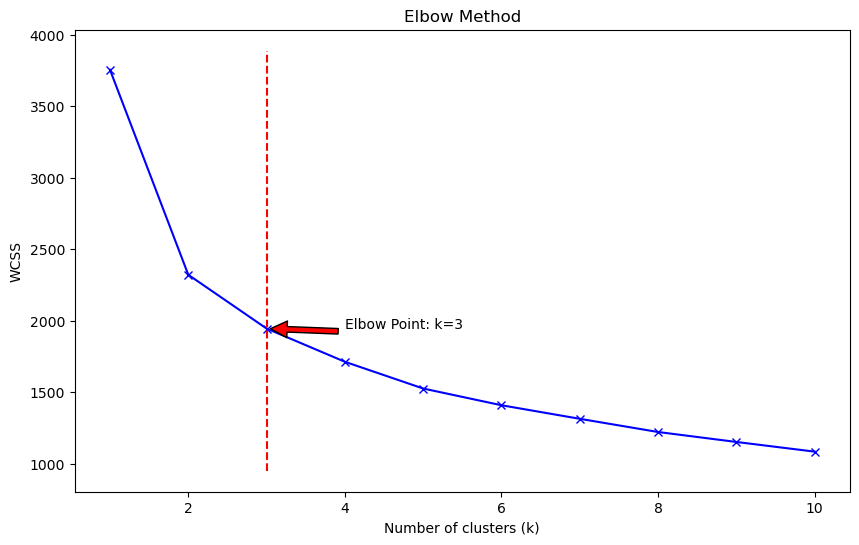

In [4]:
# 1. Optimal Number of Clusters:
# Apply the "elbow" rule (a.k.a. "knee" method) on the dataset to determine the optimal number of
# clusters K0.

# Calculate the optimal number of clusters using the elbow method
wcss = [] # Within-Cluster-Sum-of-Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Finds the elbow point
k_values = range(1, 11)
kneedle = KneeLocator(k_values, wcss, S=1.0, curve="convex", direction="decreasing")
elbow_point = kneedle.knee

# Plots the elbow point automatically :D, the result is 3
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, 'bx-')
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='r')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.annotate(f'Elbow Point: k={elbow_point}', 
            (elbow_point, wcss[elbow_point-1]),
            xytext=(elbow_point+1, wcss[elbow_point-1]),
            arrowprops=dict(facecolor='red', shrink=0.05))
plt.show()

K0 = elbow_point

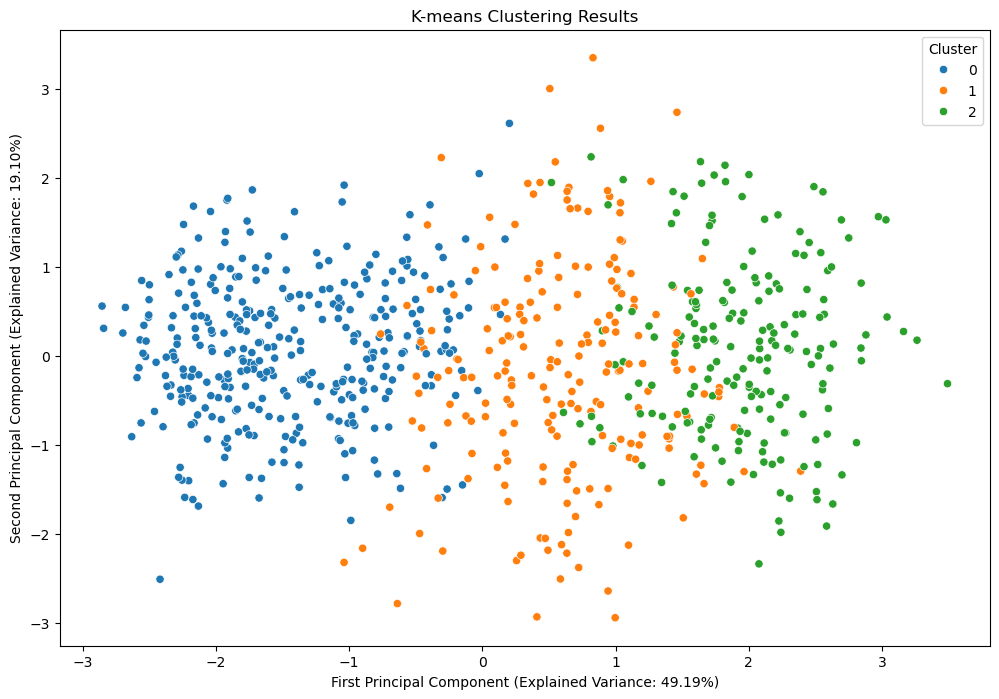

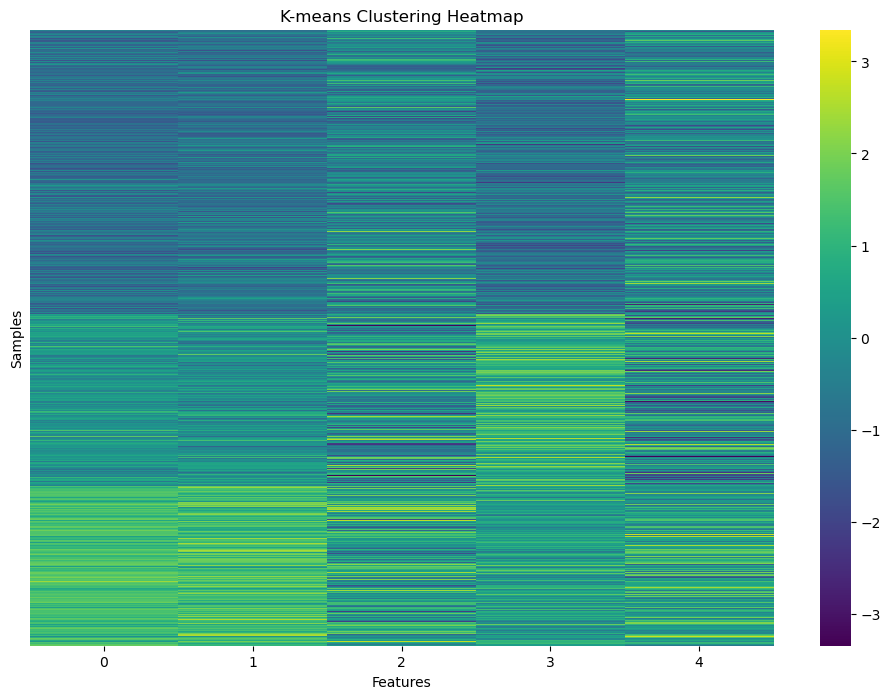

In [5]:
# 2. K-Means Clustering:
# a. Apply the K-means clustering algorithm on the dataset using K = K0 .
# b. Visualize the clusters using a scatter plot with dimensionality reduction (e.g., PCA).
# c. Create a heatmap to illustrate the clustering results.

# Apply K-means clustering
kmeans = KMeans(n_clusters=int(K0), 
                init='k-means++', 
                max_iter=300, 
                n_init=10, 
                random_state=0)
kmeans.fit(df_scaled)

df['Cluster'] = kmeans.labels_

# Visualize the clusters using PCA
pca = PCA(n_components=2)
df_pca = pd.DataFrame(
    pca.fit_transform(df_scaled),
    columns=['PC1', 'PC2']
)
df_pca['Cluster'] = kmeans.labels_

plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=df_pca, 
                         x='PC1', 
                         y='PC2', 
                         hue='Cluster', 
                         palette='tab10',
                         legend='full')
plt.title('K-means Clustering Results')
plt.xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
plt.show()

# Create a heatmap to illustrate the clustering results
sorted_idx = np.argsort(kmeans.labels_)
sorted_data = df_scaled[sorted_idx]

plt.figure(figsize=(12, 8))
sns.heatmap(sorted_data, 
            cmap='viridis',
            xticklabels=True,
            yticklabels=False)
plt.title('K-means Clustering Heatmap')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()


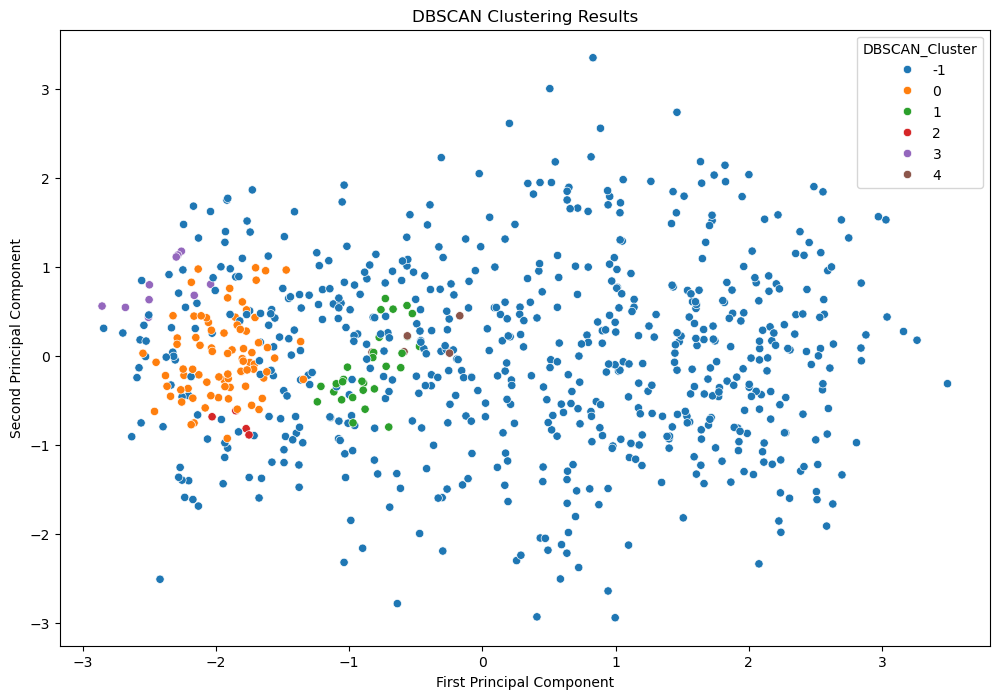

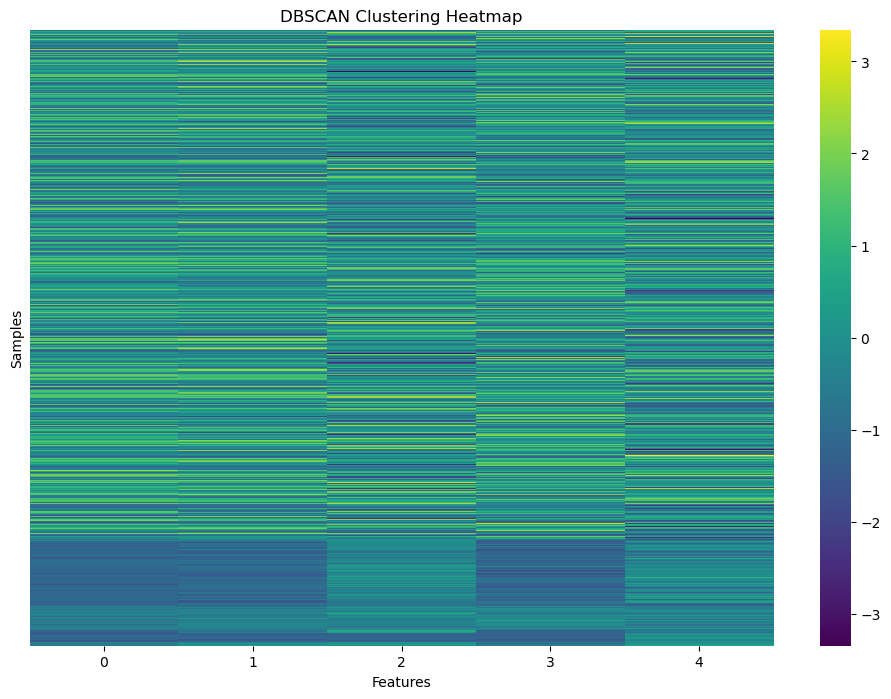

In [6]:
# 3. DBSCAN Clustering:
# a. Apply the DBSCAN clustering algorithm with ε=0.5 and minPts= 5.
# b. Visualize the clusters using a scatter plot with dimensionality reduction (e.g., PCA).
# c. Create a heatmap to illustrate the clustering results.

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(df_scaled)

df['DBSCAN_Cluster'] = dbscan.labels_
df_pca['DBSCAN_Cluster'] = dbscan.labels_

# Visualize the clusters using PCA
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=df_pca, 
                         x='PC1', 
                         y='PC2', 
                         hue='DBSCAN_Cluster', 
                         palette='tab10',
                         legend='full')
plt.title('DBSCAN Clustering Results')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# Create a heatmap to illustrate the clustering results
sorted_idx = np.argsort(dbscan.labels_)
sorted_data = df_scaled[sorted_idx]

plt.figure(figsize=(12, 8))
sns.heatmap(sorted_data, 
            cmap='viridis',
            xticklabels=True,
            yticklabels=False)
plt.title('DBSCAN Clustering Heatmap')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()


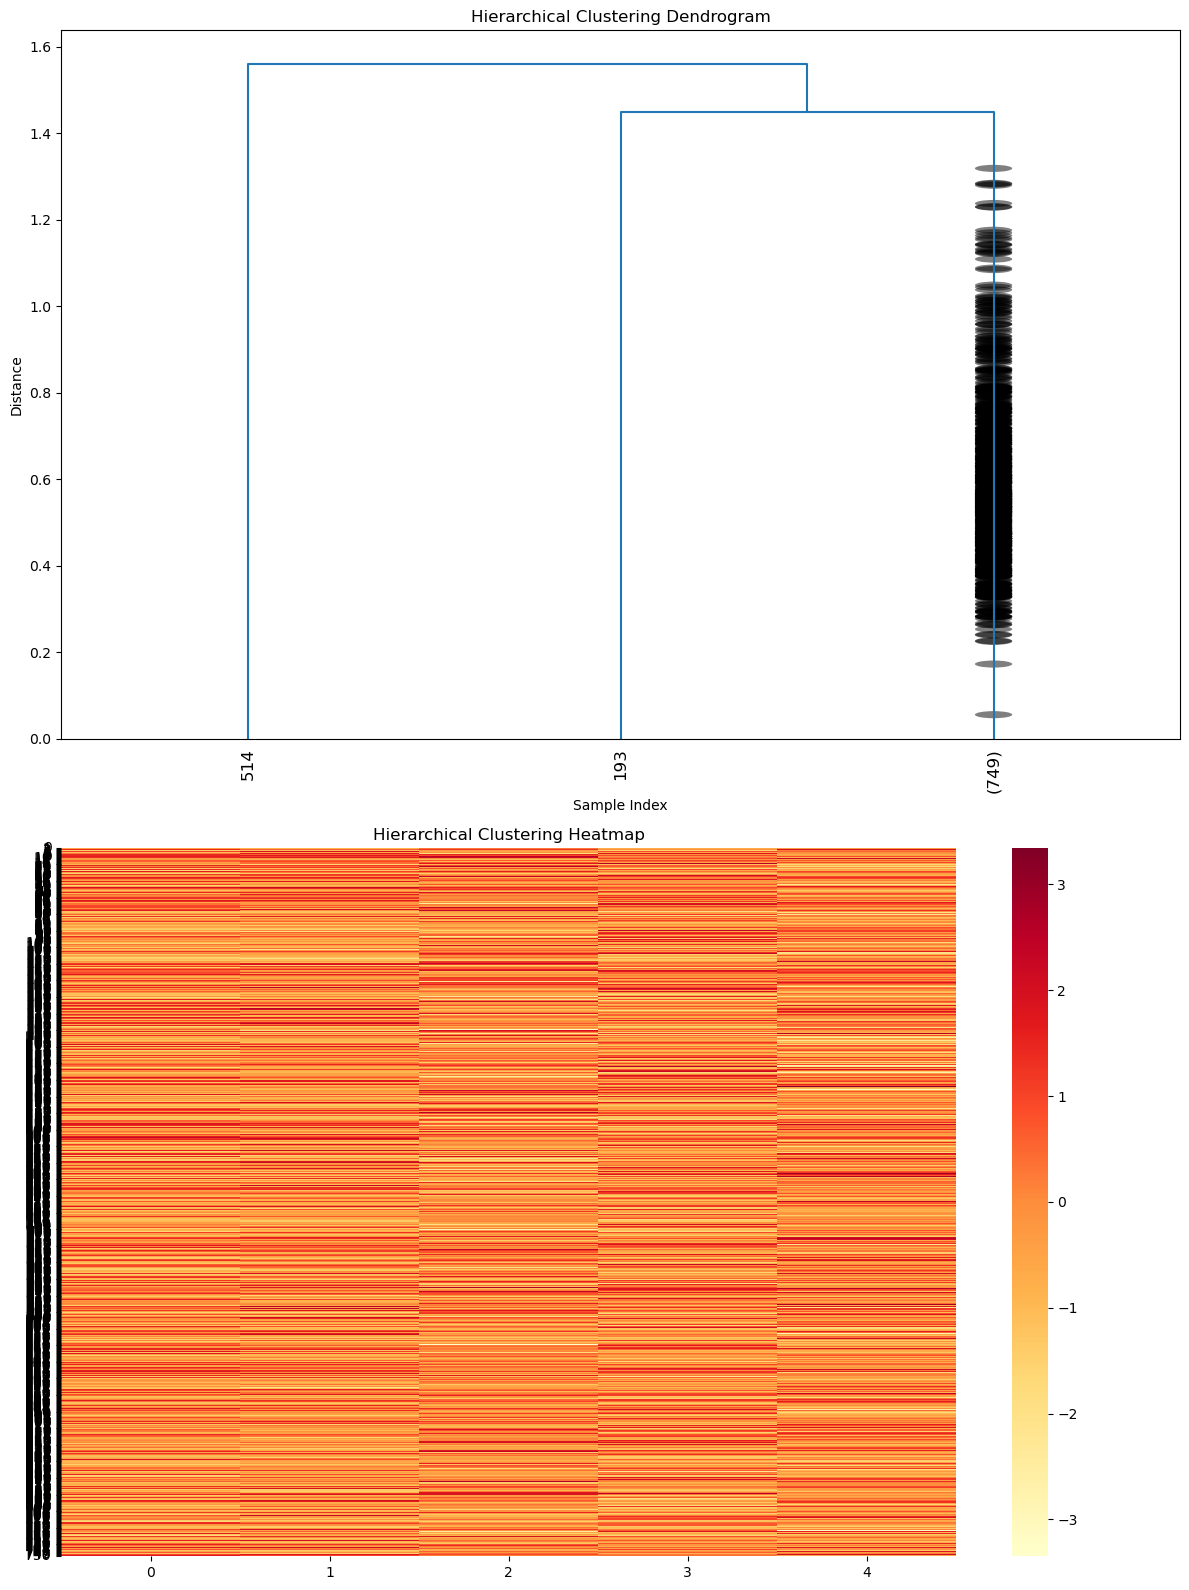

In [7]:
# 4. Hierarchical Clustering:
# a. Apply single-linkage hierarchical clustering to K0 partitions.
# b. Visualize the clusters using a scatter plot with dimensionality reduction (e.g., PCA).
# c. Create a heatmap to illustrate the clustering results.

# Apply single-linkage hierarchical clustering
linkage_matrix = linkage(df_scaled, method='single')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))

# Visualize the clusters using PCA
dendrogram(linkage_matrix, 
          p=int(K0),
          truncate_mode='lastp', 
          leaf_rotation=90, 
          leaf_font_size=12, 
          show_contracted=True,
          ax=ax1
         )

ax1.set_title('Hierarchical Clustering Dendrogram')
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Distance')

sns.heatmap(df_scaled, 
           cmap='YlOrRd',
           xticklabels=True,
           yticklabels=True,
           ax=ax2
          )

ax2.set_title('Hierarchical Clustering Heatmap')

plt.tight_layout()
plt.show()


K-Means:
Counter({0: 347, 1: 209, 2: 195})
Counter({0: 188, 1: 188, 2: 188, 3: 187})
ARI: 0.5778716672359424
Silhouette Score: 0.2971492413838459
DBSCAN:
Counter({-1: 623, 0: 80, 1: 29, 3: 10, 4: 5, 2: 4})
Counter({0: 188, 1: 188, 2: 188, 3: 187})
ARI: 0.06619162598862485
Silhouette Score: -0.2088344687088828
Hierarchical:
Counter({0: 749, 2: 1, 1: 1})
Counter({0: 188, 1: 188, 2: 188, 3: 187})
ARI: -7.0890897726883364e-06
Silhouette Score: 0.04337364443910643


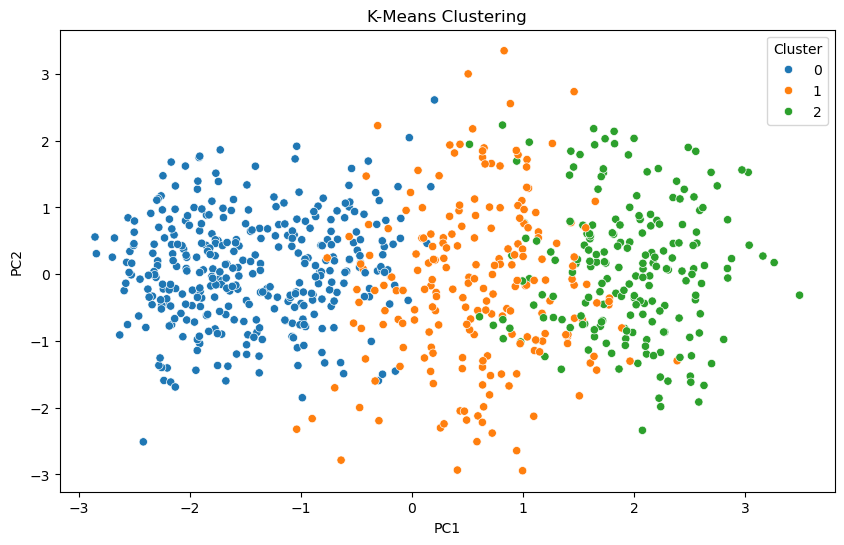

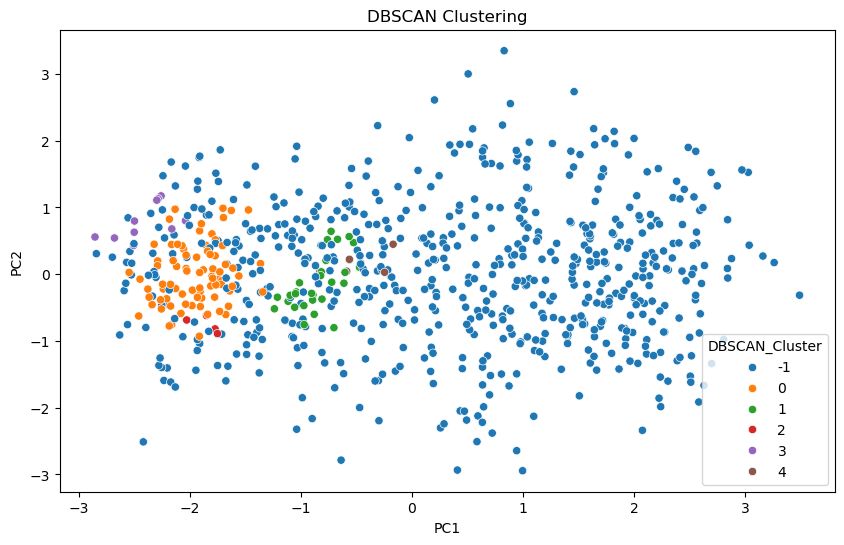

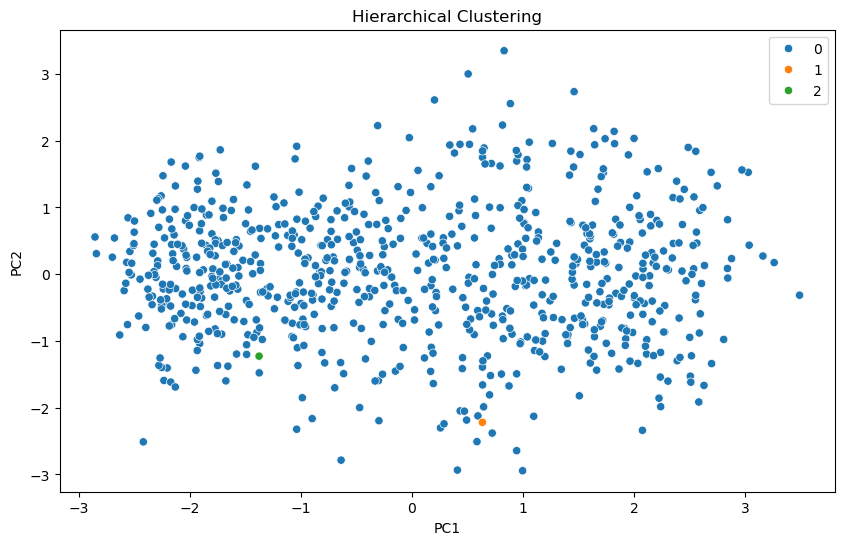

In [8]:
# 5. Comparison:
# Briefly compare the clustering results of K-means, DBSCAN, hierarchical clustering with the
# real (natural) clusters in terms of:
#  Cluster distribution
#  Cluster sizes
#  Visualization patterns

# K-Means
print('K-Means:')
print(Counter(kmeans.labels_))
print(Counter(true_labels))
print('ARI:', adjusted_rand_score(kmeans.labels_, true_labels))
print('Silhouette Score:', silhouette_score(df_scaled, kmeans.labels_))

# DBSCAN
print('DBSCAN:')
print(Counter(dbscan.labels_))
print(Counter(true_labels))
print('ARI:', adjusted_rand_score(dbscan.labels_, true_labels))
print('Silhouette Score:', silhouette_score(df_scaled, dbscan.labels_))

# Hierarchical
print('Hierarchical:')
hierarchical = AgglomerativeClustering(n_clusters=int(K0), linkage='single')
hierarchical.fit(df_scaled)
print(Counter(hierarchical.labels_))
print(Counter(true_labels))
print('ARI:', adjusted_rand_score(hierarchical.labels_, true_labels))
print('Silhouette Score:', silhouette_score(df_scaled, hierarchical.labels_))

# Visualization
# K-Means
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Cluster', palette='tab10')
plt.title('K-Means Clustering')
plt.show()

# DBSCAN
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='DBSCAN_Cluster', palette='tab10')
plt.title('DBSCAN Clustering')
plt.show()

# Hierarchical
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue=hierarchical.labels_, palette='tab10')
plt.title('Hierarchical Clustering')
plt.show()